## Numerical Linear Algebra Coursework
Module: MA50178

## Q1 / Preamble Code

Code and Markdown comments are copied from Q1 of MA50178 coursework (cw). The code has been split into code cells as it appears in the cw document and numbered in order. Documented findings can be found at the end of the question.

In [36]:
#1.1 imports
from sklearn.datasets import fetch_openml
from skimage.transform import radon
import numpy as np
import matplotlib.pyplot as plt

We start by loading a set of images $x_i \in R^n$

In [37]:
#1.2 Data Loading
X, y = fetch_openml("mnist_784", version=1, return_X_y=True,
                    as_frame=False, parser="pandas")
X = X.astype('double')

Here and below, please familiarise yourself with all objects, e.g., via X.shape. They can also be visualised either as vectors or reshaped as images. The latter is usually more useful and can be done with the following code.

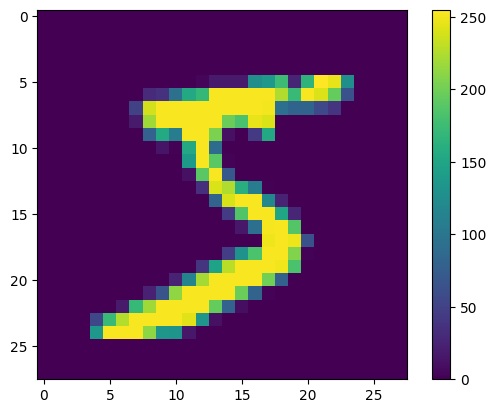

In [38]:
#1.3 Image Generation
imsize = (28, 28)


def show_image(x):
    plt.imshow(np.reshape(x, imsize))
    plt.colorbar()


show_image(X[0])

We then construct the matrix R which represents our imaging system and create a data set f (this would usually be measured by a scanner, e.g., at a hospital). To this end, we first define the function trans which models the physics.

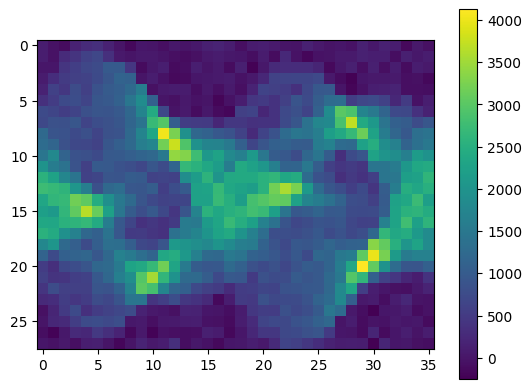

In [49]:
#1.4 trans function
theta = range(0, 359, 10)


def trans(x):
    return radon(np.reshape(x, imsize), theta)


f = trans(X[0])
f += 100 * np.random.standard_normal(f.shape)
plt.imshow(f)
plt.colorbar()

The effect of this function can be best visualised by its action on a standard normal vector, or in imaging-speak, a point-source.


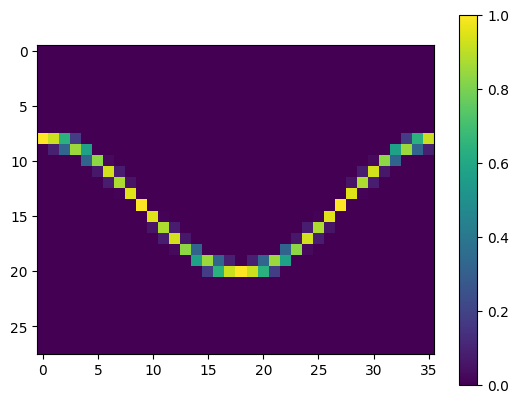

In [48]:
#1.5 Visualising effect of trans
n = np.prod(imsize)
e = np.zeros(n)
e[400] = 1
show_image(e)
Re = trans(e)
plt.imshow(Re)

Now we are in a position to compute R.

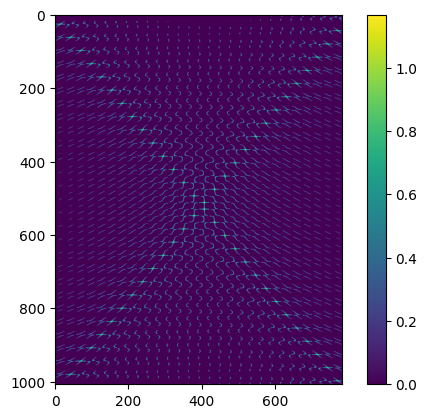

In [42]:
#1.6 Computing R
m = Re.size
e = np.zeros(n)
R = np.zeros((m, n))
for i in range(len(e)):
    e[i] = 1
    R[:, i] = trans(e).ravel()
    e[i] = 0
plt.imshow(R)
plt.colorbar()

As discussed in the lecture, we will try to solve $Rx=f$ via $Ax=b$ with $A=R^TR$ and$b=R^Tf$.

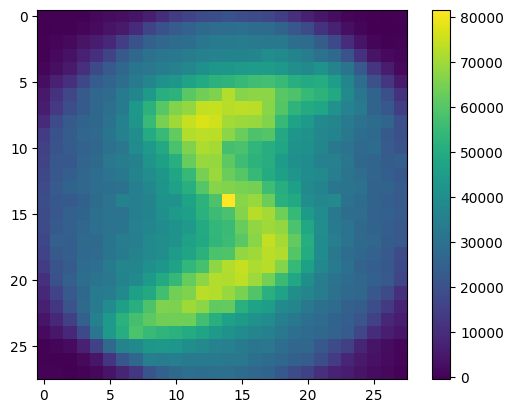

In [47]:
#1.7 Solving
A = R.T @ R
b = R.T @ f.ravel()
show_image(b)

It turns out that an inversion of this system directly does not work well.

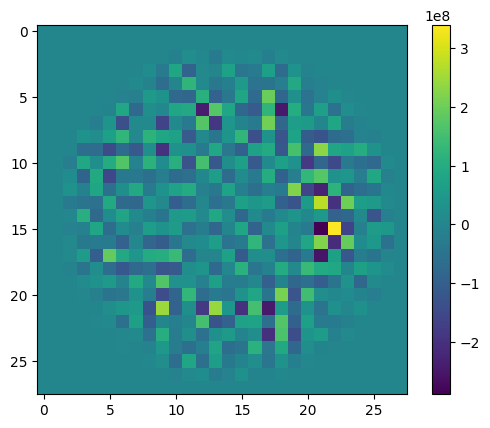

In [45]:
#1.8 Inversion attempt at solving:
xb = np.linalg.solve(A, b)
show_image(xb)

If we instead solve a “regularised” system $A_\alpha x = b$ with $A_\alpha = A + \alpha I$, we recover our ground truth image $x$ well.

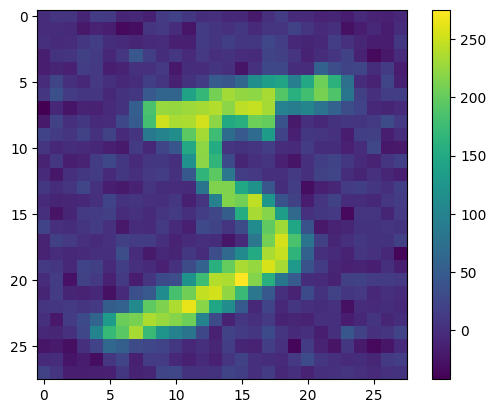

In [46]:
#1.9 Attempt 2 (regularised system):
Aalpha = A + 10 * np.eye(784)
xalpha = np.linalg.solve(Aalpha, b)
show_image(xalpha)

# Q1 Documented Findings
Code blocks 1.1-1.3: THis loads the MNist-784 dataset, a dataset containing 70,000 samples of hand drawn digits (0-9) stored as 28*28 pixel images with each pixel assigned a value between 0 and 255, this is likely a value denoting the presence of 'ink' or similar on a blank surface. This is stored as an array X with X[0] being an image of a hand drawn 5.

Code blocks 1.4-1.5: These introduce the trans function, effectively a wrapper for the radon function which takes an image and returns its sinogram (a set of projections of the image into a single dimension by cutting rays at different angles across the image). 1.5 then shows an example of this.

Code blocks 1.6-1.7: This creates the $R$ matrix as setup for our linear algebra problem by operating the trans function on each pixel of the X[0] image one at a time. R then becomes a (1008,784) matrix where 784 comes from the image size ($28^2$) and 1008 is the number of datapoints created from the trans function for a single image. $A = R^T \times R$ and $b = R \times f$ are then generated ($f$ has been 'flattened' here to allow for matrix multiplication).

Code block 1.8: Here an attempt is made to solve the system using np.linalg.solve(). The noise added causes issues for the solver and creates a very noisy 'solution'.

Code block 1.9: Another attempt is made to solve the system here, this time using $A_\alpha = A + 10I$. This is called regularisation and provides multiple advantages.
Firstly, $\sigma(A_\alpha) = \sigma(A) + 10$ i.e. $\lambda_{\alpha,i} = \lambda_{A,i} + 10 \quad \forall \lambda_{A,i} \in \sigma(A)$. This reduces the sensitivity of the system with respect to small changes in the initial data as $\lambda_{max}/\lambda_{min}\approx 1$. This is helpful as $||A_{\alpha}|| \approx ||A_{\alpha}^{-1}||$ so the inverse won't be badly affected by noise in the system.
Secondly, the regularisation penalises solutions where large components come from directions associated with small eigenvalues of the system (i.e. the solver favours larger eigenvalues for constructing the solution).

### Q2 Implementation of G-S
Here we first define a function using G-S with the same arguements as np.linalg.solve().

In [46]:
def GaussSeidelSolve(A,b,tol=):
    #defining; D,L,U
    D = np.diag(A)
    L = np.tril(A)
    U = np.triu(A)
